In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [27]:
left_side_road_coordinates = pd.read_csv('RL_map_training/road_left.csv')
right_side_road_coordinates = pd.read_csv('RL_map_training/road_right.csv')

In [28]:
right_side_list_coordinates = list(zip(right_side_road_coordinates.x_values, right_side_road_coordinates.y_values))
left_side_list_coordinates = list(zip(left_side_road_coordinates.x_values, left_side_road_coordinates.y_values))


In [29]:
def get_middle_point(coordinates: tuple, list_coordinates: list[tuple]):
    min_distance = 100000
    closest_point = None

    for temp_coordinates in list_coordinates:
        distance = ((coordinates[0] - temp_coordinates[0]) ** 2 + (coordinates[1] - temp_coordinates[1]) ** 2) ** 0.5
        if distance < min_distance:
            min_distance = distance
            closest_point = temp_coordinates

            # get midlle of coordinates and closest point
            x_middle = (coordinates[0] + closest_point[0]) / 2
            y_middle = (coordinates[1] + closest_point[1]) / 2
            middle_point = (x_middle, y_middle)


    return middle_point

In [30]:
middle_side_list_coordinates = []

for points in left_side_list_coordinates:
    middle_point = get_middle_point(points, right_side_list_coordinates)
    middle_side_list_coordinates.append(middle_point)

with open('RL_map_training/road_middle.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['x_values', 'y_values'])
    writer.writerows(middle_side_list_coordinates)

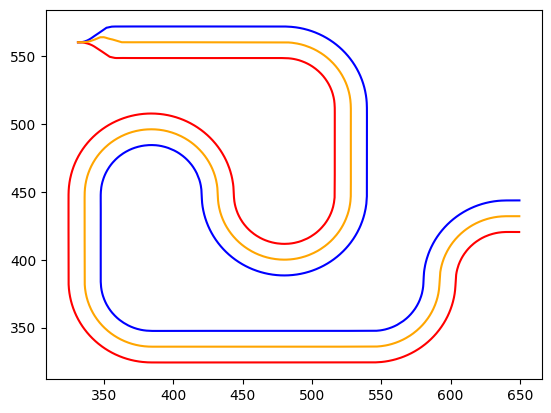

In [31]:
left_side_road_coordinates = pd.read_csv('RL_map_training/road_left.csv')
right_side_road_coordinates = pd.read_csv('RL_map_training/road_right.csv')
middle_side_road_coordinates = pd.read_csv('RL_map_training/road_middle.csv')

fig, ax = plt.subplots()

ax.plot(left_side_road_coordinates.x_values, left_side_road_coordinates.y_values, color='blue')
ax.plot(right_side_road_coordinates.x_values, right_side_road_coordinates.y_values, color='red')
ax.plot(middle_side_road_coordinates.x_values, middle_side_road_coordinates.y_values, color='orange')

plt.show()